# Research of Ramen Restaurant in Tokyo
This notbook is for Applied Data Science Capstone project  
--- Norimoto Ichikawa ---

# 1. Introduction
There are various types of restaurants in Tokyo where has the most restaurants listed in the Michelin guide in the world. Especially Ramen (Japanese noodle) is a unique and a representative food of Japan which is strongly recommend for foreign tourists.

Its taste and style are completely unique in each restaurant, I strongly recommend trying several restaurants when foreigners visit to Tokyo. But there are a lot of Ramen restaurants anywhere in Tokyo. This research will show which location in Tokyo is convenient to stay and enjoy Ramens. The central area of Tokyo is divided into 23 special wards (called “Ku”). This research only focuses on the 23 special wards area, and compares each ward.


In [6]:
import pandas as pd
import numpy as np

# 2. Data Description
1)	Wikipedia “Special wards of Tokyo”  
https://en.wikipedia.org/wiki/Special_wards_of_Tokyo  
I got each sward information from the table in Wikipedia scraping with BeautifulSoup 
  
Since several tables are existing in the page, I selected only “wilitable sortable” class which only the target table uses. After scraping, I cleaned data such as removing rows of “No.”, “Flag”, and “Kanji”, and renaming “Population (as of October 2016)” to “Population”, and “OtaŌta” to “Ōta”.

In [7]:
from bs4 import BeautifulSoup
import requests

#Scrape table from Wikipedia
url = "https://en.wikipedia.org/wiki/Special_wards_of_Tokyo"
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

#Convert to data frame
table_contents=[]
table=soup.find('table',{'class':'wikitable sortable'})
rows = table.find_all('tr')
columns = [v.text.replace('\n', '') for v in rows[0].find_all('th')]
columns[4] = 'Population'
df = pd.DataFrame(columns=columns)
for i in range(len(rows)):
    tds = rows[i].find_all('td')
    if len(tds) == len(columns):
        values = [ td.text.replace('\n', '').replace('\xa0', ' ') for td in tds ]
        df = df.append(pd.Series(values, index=columns), ignore_index= True)
df = df.drop(['No.','Flag','Kanji'],axis=1)
df['Name'] = df['Name'].replace({'OtaŌta':'Ōta'})
df

,Name,Population,Density(/km2),Area(km2),Major districts
0,Chiyoda,"0059,441","05,100",011.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,Chūō,"0147,620","14,460",010.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,Minato,"0248,071","12,180",020.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,Shinjuku,"0339,211","18,620",018.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,Bunkyō,"0223,389","19,790",011.29,"Hongō, Yayoi, Hakusan"
5,Taitō,"0200,486","19,830",010.11,"Ueno, Asakusa"
6,Sumida,"0260,358","18,910",013.77,"Kinshichō, Morishita, Ryōgoku"
7,Kōtō,"0502,579","12,510",040.16,"Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō,..."
8,Shinagawa,"0392,492","17,180",022.84,"Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi,..."
9,Meguro,"0280,283","19,110",014.67,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai"


2)	Geocoder
I got Latitude and Longitude of each special ward using Geocoder.


In [8]:
pip install geocoder

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 14.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Searching address such as “Chiyoda-ku, Tokyo” and getting Latitude and Longitude of typical location of each ward. Latitude and Longitude are added to the wards list

In [9]:
import geocoder # import geocoder
latitude=[]
longitude=[]
for name in df['Name']:
    g = geocoder.arcgis('{}-ku, Tokyo'.format(name))
#    print(name, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}-ku, Tokyo'.format(name))
#        print(name, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

df['Latitude'] = latitude
df['Longitude'] = longitude
df

,Name,Population,Density(/km2),Area(km2),Major districts,Latitude,Longitude
0,Chiyoda,"0059,441","05,100",011.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.693930,139.753711
1,Chūō,"0147,620","14,460",010.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",35.670572,139.771988
2,Minato,"0248,071","12,180",020.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",35.658017,139.751546
3,Shinjuku,"0339,211","18,620",018.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",35.693798,139.703440
4,Bunkyō,"0223,389","19,790",011.29,"Hongō, Yayoi, Hakusan",35.707595,139.752210
5,Taitō,"0200,486","19,830",010.11,"Ueno, Asakusa",35.712595,139.779986
6,Sumida,"0260,358","18,910",013.77,"Kinshichō, Morishita, Ryōgoku",35.710707,139.801540
7,Kōtō,"0502,579","12,510",040.16,"Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō,...",35.672823,139.817290
8,Shinagawa,"0392,492","17,180",022.84,"Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi,...",35.609160,139.730161
9,Meguro,"0280,283","19,110",014.67,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai",35.641490,139.698273


3)	Forsquare API  
https://developer.foursquare.com/docs/api-reference/venues/explore/  
I got Ramen restaurants in each sward using Forsquare API. Actually I had wanted to use popularity data of each restaurant such as rating and number of likes, however “Get Details of a Venue” API is Premium endpoint which only 50 calls per day is acceptable in my free account. Thus, I gave up to use popularity data, and used only location data in this research.

In [10]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 8.3 MB/s  eta 0:00:01


4)	folium 
I used folium to show maps with location data.


In [12]:
# create map of Toronto using latitude and longitude values
g = geocoder.arcgis('Tokyo, Japan')
map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

# 3. Methodology
# 3.3	Get Ramen restaurants in each sward using Foursquare
“Get Venue Recommendations” API of Foursquare is used to get Ramen restaurants in each sward.  
https://developer.foursquare.com/docs/api-reference/venues/explore/  
To select Ramen restaurant only, categoryid was set as “55a59bace4b013909087cb24” which is “Ramen Restaurant”.  
https://developer.foursquare.com/docs/build-with-foursquare/categories/  
Radius is set as 100,000m because restaurants are searched by sward name and radius is not used.  
sortByPopularity = 1 option was used to get only higher popularity restaurants were used.  
At first, the number of restaurants in each sward had been limited as 100 to avoid over API calls, however I found that some swards didn’t achieve to 100.


In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=100000):
    
    LIMIT = 40 # A default Foursquare API limit value
    
    venues_list=[]
    categoryid = '55a59bace4b013909087cb24'
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&near={}&radius={}&limit={}&categoryId={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            name,
            radius, 
            LIMIT,
            categoryid
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Chiyoda
Chūō
Minato
Shinjuku
Bunkyō
Taitō
Sumida
Kōtō
Shinagawa
Meguro
Ōta
Setagaya
Shibuya
Nakano
Suginami
Toshima
Kita
Arakawa
Itabashi
Nerima
Adachi
Katsushika
Edogawa


In [16]:
venues

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chiyoda,35.693930,139.753711,Tsujita (つじ田),35.698808,139.770099,Ramen Restaurant
1,Chiyoda,35.693930,139.753711,雷 東京本丸店,35.681882,139.766340,Ramen Restaurant
2,Chiyoda,35.693930,139.753711,Tokyo Ramen Street (東京ラーメンストリート),35.680142,139.767873,Ramen Restaurant
3,Chiyoda,35.693930,139.753711,Honda (麺処 ほん田),35.698017,139.774240,Ramen Restaurant
4,Chiyoda,35.693930,139.753711,Bushoya (家系らーめん 武将家),35.700019,139.771998,Ramen Restaurant
...,...,...,...,...,...,...,...
915,Edogawa,35.707014,139.868367,麺屋こころ 小岩店,35.735485,139.881764,Ramen Restaurant
916,Edogawa,35.707014,139.868367,Ramen Yoshibe (ラーメン ヨシベー),35.664727,139.860224,Ramen Restaurant
917,Edogawa,35.707014,139.868367,Misoichi (味噌一),35.690402,139.882639,Ramen Restaurant
918,Edogawa,35.707014,139.868367,宝来軒,35.669893,139.874578,Ramen Restaurant


In [17]:
import matplotlib.pyplot as plt

<BarContainer object of 23 artists>

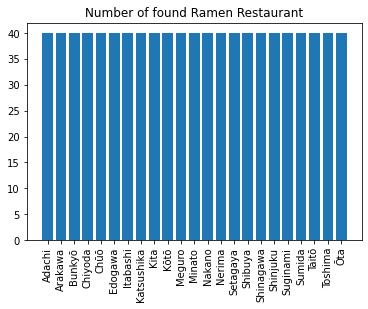

In [18]:
values= venues.groupby('Ward').count()
plt.xticks(rotation=90)
plt.title("Number of found Ramen Restaurant")
plt.bar(values.index, values['Venue Category'])

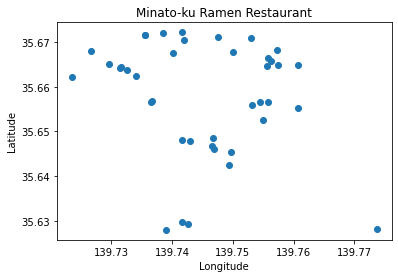

In [19]:
ward = 'Minato'
latitude = venues[venues['Ward'] == ward]['Venue Latitude']
longitude = venues[venues['Ward'] == ward]['Venue Longitude']
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title("{}-ku Ramen Restaurant".format(ward))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.scatter(longitude, latitude)

In [20]:
ward = 'Kōtō'

# create map of Toronto using latitude and longitude values
g = geocoder.arcgis('{}-ku, Tokyo'.format(ward))
map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=14)

# add markers to map
for lat, lng, label in zip(venues[venues['Ward'] == ward]['Venue Latitude'],
                           venues[venues['Ward'] == ward]['Venue Longitude'],
                           venues[venues['Ward'] == ward]['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#fe6ccf',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

# Calculate centroid of Ramen restaurant in each sward
To see deviation of distance from centroid in each sward, centroids of all Ramen restaurant in each sward was calculated using “groupby().mean()” method.


In [21]:
wards = venues.groupby('Ward').mean()
wards

,Ward Latitude,Ward Longitude,Venue Latitude,Venue Longitude
Ward,,,,
Adachi,35.774811,139.804537,35.769489,139.808063
Arakawa,35.736093,139.783403,35.737450,139.775122
Bunkyō,35.707595,139.752210,35.702008,139.762715
Chiyoda,35.693930,139.753711,35.695866,139.769709
Chūō,35.670572,139.771988,35.676320,139.772320
Edogawa,35.707014,139.868367,35.688505,139.870983
Itabashi,35.751074,139.709194,35.767604,139.683700
Katsushika,35.743454,139.847229,35.744980,139.854937
Kita,35.752839,139.733519,35.763150,139.727331


Blue is the typical location of each sward, and red is the centroid of Ramen restaurants in each sward.

In [22]:
# create map of Toronto using latitude and longitude values
g = geocoder.arcgis('Tokyo, Japan')
map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
for lat, lng, label in zip(wards['Venue Latitude'], wards['Venue Longitude'], wards.index):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#fe6ccf',
        fill_opacity=0.7,
        parse_html=False).add_to(map)      
    
map

# Calculate distance between each Ramen restaurant and a centroid
To calculate a distance between 2 locations in Latitude and Longitude, geopy.distance was used.


In [23]:
from geopy.distance import geodesic
distances=[]
for lat, lng, label in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Ward']):
    centerlat = wards.loc[label]['Venue Latitude']
    centerlng = wards.loc[label]['Venue Longitude']
    distance = geodesic((centerlat, centerlng), (lat, lng)).km
    distances.append(distance)
venues['Distance'] = distances
venues

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
0,Chiyoda,35.693930,139.753711,Tsujita (つじ田),35.698808,139.770099,Ramen Restaurant,0.328345
1,Chiyoda,35.693930,139.753711,雷 東京本丸店,35.681882,139.766340,Ramen Restaurant,1.581240
2,Chiyoda,35.693930,139.753711,Tokyo Ramen Street (東京ラーメンストリート),35.680142,139.767873,Ramen Restaurant,1.752502
3,Chiyoda,35.693930,139.753711,Honda (麺処 ほん田),35.698017,139.774240,Ramen Restaurant,0.474461
4,Chiyoda,35.693930,139.753711,Bushoya (家系らーめん 武将家),35.700019,139.771998,Ramen Restaurant,0.505175
...,...,...,...,...,...,...,...,...
915,Edogawa,35.707014,139.868367,麺屋こころ 小岩店,35.735485,139.881764,Ramen Restaurant,5.303114
916,Edogawa,35.707014,139.868367,Ramen Yoshibe (ラーメン ヨシベー),35.664727,139.860224,Ramen Restaurant,2.812291
917,Edogawa,35.707014,139.868367,Misoichi (味噌一),35.690402,139.882639,Ramen Restaurant,1.075868
918,Edogawa,35.707014,139.868367,宝来軒,35.669893,139.874578,Ramen Restaurant,2.090511


In [26]:
ward_distances = pd.DataFrame(columns=wards.index)
for ward in wards.index:
    distance = venues[venues['Ward'] == ward]['Distance'].tolist()
    ward_distances[ward] = distance
ward_distances

Ward,Adachi,Arakawa,Bunkyō,Chiyoda,Chūō,Edogawa,Itabashi,Katsushika,Kita,Kōtō,...,Nerima,Setagaya,Shibuya,Shinagawa,Shinjuku,Suginami,Sumida,Taitō,Toshima,Ōta
0,3.715513,0.740585,0.725355,0.328345,0.476824,1.107217,3.338382,2.909538,1.687451,3.654306,...,2.352257,2.670098,0.416073,1.018255,1.447752,0.664403,0.623493,0.617763,0.288354,1.414764
1,1.700491,0.908688,0.712774,1.581240,0.575735,5.215615,0.786634,3.019877,2.465635,1.259372,...,2.845037,3.768844,0.296912,3.043850,0.344965,1.033526,0.665213,0.427579,0.277108,0.999900
2,2.133127,1.143981,0.691872,1.752502,0.367481,0.992028,2.265685,2.529932,1.307569,2.413759,...,1.549708,2.264397,2.107132,1.709780,1.693813,2.820245,0.296310,0.743831,1.428617,1.388973
3,2.257037,0.840990,0.787535,0.474461,1.823483,5.057924,2.187555,2.519922,2.225116,4.017032,...,2.301812,2.365480,1.422315,0.247790,1.082816,3.266742,0.936978,0.589185,0.227195,1.114521
4,2.808380,0.722718,1.798864,0.505175,0.734498,2.765419,0.461164,2.970562,0.300712,3.118486,...,1.610847,3.849582,1.985996,1.692662,0.651672,2.815684,0.399740,0.161376,0.741300,1.362018
5,2.218167,0.846425,0.775960,0.448851,1.948922,5.110608,2.332456,2.888723,1.776672,0.979709,...,3.835448,4.123214,0.183586,0.695105,3.057306,2.771145,1.155246,0.384023,0.250272,5.139746
6,3.149593,1.578608,0.694175,0.720856,1.085234,2.968077,0.978494,3.030870,1.629006,2.869472,...,1.737374,2.644488,0.502001,1.209750,0.678532,1.840118,1.171640,0.534164,0.400352,4.875579
7,2.649948,1.683418,0.826926,0.549560,1.399624,2.759933,1.210279,2.752558,1.426782,3.351639,...,1.611481,4.638400,0.447994,1.032861,0.770620,2.200889,0.413963,0.769467,0.438373,0.917471
8,2.329732,0.721189,2.255764,1.763365,0.574853,3.432888,1.668724,3.146317,3.842303,2.351832,...,3.262921,2.668218,0.252054,1.000309,0.605121,1.942732,0.634557,0.529198,0.246863,1.404960
9,2.204741,0.434172,0.625533,0.350186,1.504082,2.786925,2.230152,3.273368,0.499379,3.298753,...,4.493330,2.442707,0.326620,1.403538,0.376647,2.681052,0.337669,2.012570,0.145229,1.751553


In [27]:
describe = ward_distances.describe().transpose()
describe = describe.drop('count', axis=1)
describe

,mean,std,min,25%,50%,75%,max
Ward,,,,,,,
Adachi,2.192385,0.655676,0.566281,1.898154,2.168047,2.506668,3.715513
Arakawa,1.067880,0.405522,0.434172,0.804309,0.972008,1.256572,2.247907
Bunkyō,0.775298,0.345828,0.277652,0.647688,0.721997,0.809847,2.255764
Chiyoda,0.759070,0.497580,0.272763,0.480517,0.606993,0.772592,2.207177
Chūō,1.030066,0.510369,0.033412,0.603748,0.972691,1.392079,2.000742
Edogawa,3.012988,1.326232,0.690393,2.633539,2.879225,3.424366,5.647414
Itabashi,2.307524,1.268142,0.461164,1.437933,1.896246,3.152462,4.913928
Katsushika,2.492202,0.952937,0.103615,2.407485,2.820641,3.126736,3.487477
Kita,1.748695,0.937671,0.230776,1.320687,1.771693,2.081480,4.010110


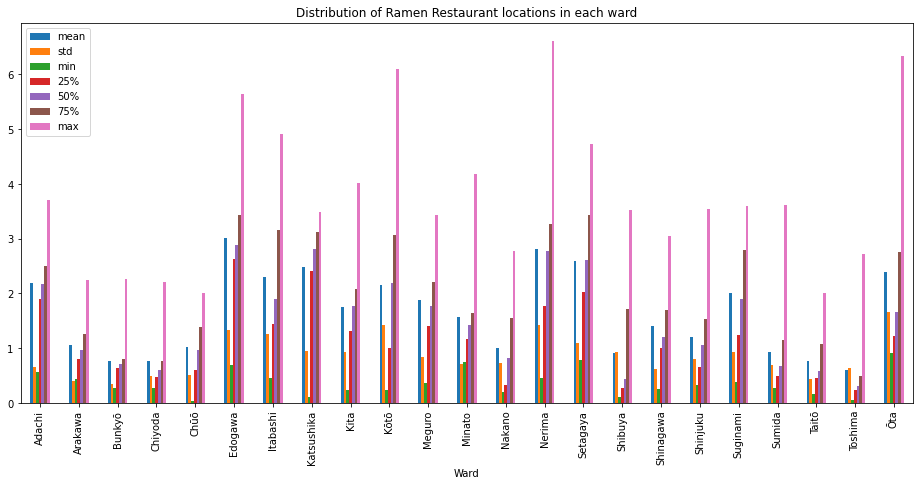

In [28]:
describe.plot(kind='bar', figsize=(16, 7))
plt.xticks(rotation=90)
plt.title("Distribution of Ramen Restaurant locations in each ward")
plt.show()

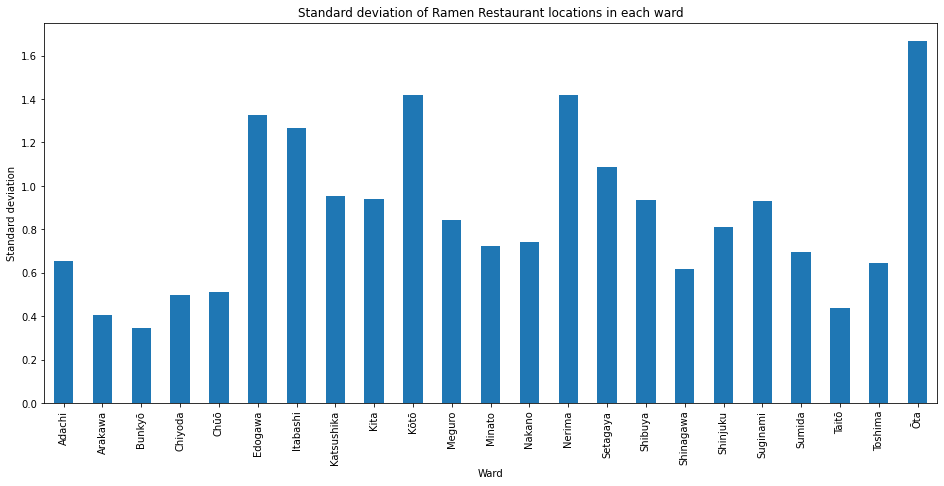

In [29]:
describe['std'].plot(kind='bar', figsize=(16, 7))
plt.xticks(rotation=90)
plt.title("Standard deviation of Ramen Restaurant locations in each ward")
plt.ylabel("Standard deviation")
plt.show()

The smaller distribution and the shorter average of distance may be the more convenient to visit several restaurants in the location. 

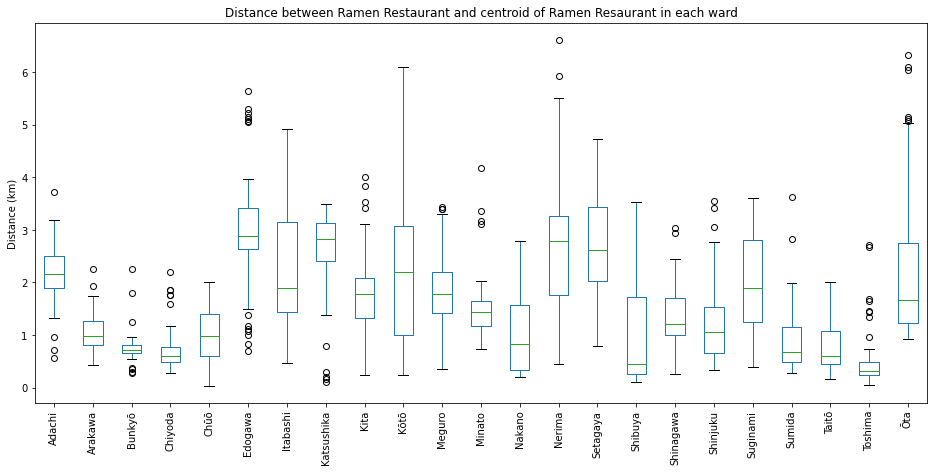

In [30]:
ward_distances.plot(kind='box', figsize=(16, 7))
plt.xticks(rotation=90)
plt.title("Distance between Ramen Restaurant and centroid of Ramen Resaurant in each ward")
plt.ylabel("Distance (km)")
plt.show()

# Clustering based on distribution of distance
The distribution of distance of each restaurant was summarized using describe() method and clustered using K-mean (K=5).

In [31]:
from sklearn.cluster import KMeans

In [32]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(describe)

describe['Cluster'] = kmeans.labels_
describe

,mean,std,min,25%,50%,75%,max,Cluster
Ward,,,,,,,,
Adachi,2.192385,0.655676,0.566281,1.898154,2.168047,2.506668,3.715513,3
Arakawa,1.067880,0.405522,0.434172,0.804309,0.972008,1.256572,2.247907,0
Bunkyō,0.775298,0.345828,0.277652,0.647688,0.721997,0.809847,2.255764,0
Chiyoda,0.759070,0.497580,0.272763,0.480517,0.606993,0.772592,2.207177,0
Chūō,1.030066,0.510369,0.033412,0.603748,0.972691,1.392079,2.000742,0
Edogawa,3.012988,1.326232,0.690393,2.633539,2.879225,3.424366,5.647414,1
Itabashi,2.307524,1.268142,0.461164,1.437933,1.896246,3.152462,4.913928,1
Katsushika,2.492202,0.952937,0.103615,2.407485,2.820641,3.126736,3.487477,1
Kita,1.748695,0.937671,0.230776,1.320687,1.771693,2.081480,4.010110,3


In [33]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map of Toronto using latitude and longitude values
g = geocoder.arcgis('Tokyo, Japan')
map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    cluster = describe['Cluster'][label]
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map)  

map

# 4. Results
Looking on the distribution of the box plot, Toshima-ku is small distribution and short average.  
This is the map of each Ramen restaurant in Toshima-ku. There is a large terminal station called Ikebukuro station in Toshima-ku. Many Ramen restaurants are gathering around the station and looks convenient to visit many restaurants.

# 5. Discussion
As I mentioned in section 2, I had supposed to use popularity data of each restaurant. Because taste of popular restaurant and non-populer restaurant are completely difference in case of Ramen restaurant, however I could not use it due to restriction of API call. But I think, interesting result was made even though only location data was used.  
Although I am commuting to our office in Tokyo every day, I didn’t know which area is the most area where many Ramen restaurant are existing. Looking data can make it clear for me.  
I got another curiosity during the research that difference of characteristics depending on food type which means how other foods are different from Ramen restaurant. I will try to study later.  
# 6. Conclusion
Now I have a confidence that I can recommend some areas in Tokyo to foreign tourists and Ramen lovers.  
I can use this data science methodology to other geographical projects.
